# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Joseph Weibel</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
#!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!nvidia-smi

Thu Dec 15 09:39:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import imageio
import numpy as np

subfolder = '001'
folders = os.path.join('/content/drive/MyDrive/adni_png', subfolder)

images = np.empty([7,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.imread(f.name)
            names.insert(idx, f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            
print(images.shape)

m1-1_slice145 (256, 170)
m1-2_slice145 (256, 170)
m3-2_slice145 (256, 170)
m4-2_slice145 (256, 170)
m4-1_slice145 (256, 170)
m6-1_slice145 (256, 170)
m3-1_slice145 (256, 170)
(7, 256, 170)


In [22]:
m = images[0]
m = m -m.min() / m.max() - m.min() # normalize data 
u,s,vt = np.linalg.svd(m, full_matrices=False)

In [2]:
import numpy as np

m = np.random.normal(size=(1000, 1000))
u, s, vt = np.linalg.svd(m, full_matrices=False)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest. Diskutiere deine Entscheidungen in 150-200 Wörtern. 

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [2]:
### BEGIN SOLUTION
from numba import cuda, float32
import math


@cuda.jit
def _reconstruct_svd_gpu_1(u, s, vt, reco):
  x, y = cuda.grid(2)

  if x < u.shape[0] and y < vt.shape[0]:
    sum = 0
    for k in range(s.shape[0]):
      sum += u[x, k] * s[k] * vt[k, y]

    reco[x, y] = sum

def reconstruct_svd_gpu_1(u, s, vt, k, threads_per_block=32):
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  n_blocks_x = math.ceil(u.shape[0] / threads_per_block)
  n_blocks_y = math.ceil(vt.shape[0] / threads_per_block)

  _reconstruct_svd_gpu_1[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [13]:
import matplotlib.pyplot as plt

reco = reconstruct_svd_gpu_1(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 48 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


NameError: ignored

<font color='blue'>Bei dieser einfachen Implementierung wird die gesamte Berechnung auf der GPU vorgenommen. Jeder Thread ist für ein einzelnes Pixel in der Rekonstruktion verantwortlich. Das Kürzen der Matrizen und Vektoren auf n Komponenten wird auf der CPU vorgenommen, beziehungsweise werden nur die nötigen Elemente auf die GPU kopiert. Dadurch wird verhindert, dass Elemente zur GPU kopiert werden, die dort gar nicht benötigt werden.

Die Anzahl Threads pro Block kann dabei frei definiert werden. Kleinere Grössen können sinnvoll sein, um dadurch die Rekonstruktionsgrösse genau aufteilen zu können, so dass möglichst keine Threads leer laufen. Bei einer Breite von 2000 px wäre es sinnvoller 25 oder 16 statt 32 zu verwenden.
TODO: stimmt das?

Es wird numba verwendet, da damit die grundelegenden GPU-Operationen simuliert werden können. Zudem kann damit Python-Code geschrieben werden, der dann autoamtisch in C-Code übersetzt wird.</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Strided Access

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Strided Access durch, auf welchen dein GPU-Kernel arbeitet. Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse und welcher Strided Access hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und PGU Implementierung? Diskutiere deine Analyse in ca. 200 Wörtern und ggf. mit Grafiken. 

In [5]:
# import os
# os.environ["NUMBA_ENABLE_CUDASIM"] = "1"


In [6]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_2(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    shrd_u[local_y, local_x] = 0
    if y < u.shape[0] and (block * threads_per_block + local_x) < u.shape[1]:
      shrd_u[local_y, local_x] = u[y, block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s[local_x] = 0
      if (block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s[local_x] = s[block * threads_per_block + local_x]

    shrd_vt[local_y, local_x] = 0
    if x < vt.shape[1] and (block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt[local_y, local_x] = vt[block * threads_per_block + local_y, x]

    # wait until all tpb x tpb elements are filled
    cuda.syncthreads()

    # start calculating the sum of products for index (y, x)
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[i, local_x]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_2(u, s, vt, k):
  threads_per_block = 32
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_2[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [7]:
reco = reconstruct_svd_gpu_2(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


<font color='blue'>Die erste Version hat ein schlechtes Verhältnis von Memory- zu Computation-Operationen. Es wird bei jeder Berechnung dreimal aufs Memory zugegriffen, ohne dass diese Werte nochmals verwendet werden. Diese optimierte Variante kopiert nun blockweise die benötigten Werte ins Shared-Memory wo sie von allen Threads desselben Blocks ebenfalls verwendet werden können. Da bei diesen Matrixmultiplikationen sehr viele Elemente wiederverwendet werden können, ist diese Implementierung um einiges schneller als die letzte, auch wenn nach wie vor alle Elemente mehrmals kopiert werden, da sie auch von anderen Blocks verwendet werden.</font>

##### 5.2.2 Memoryallokation auf der GPU
Führe 2-3 Experimente durch in welchem du unterschiedliche Varianten des Transfers der Daten bzw. der Memory-Allokation auf die GPU miteinander vergleichst. Messe die Varianten mittels geeigneten Methoden. Als Beispiel können hier z.B. unterschiedlich grosse Packages an Daten auf die GPU kopiert und dann verarbeitet werden oder die Daten werden in unterschiedliche Memory-Typen geladen.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

###### Antwort

<font color='blue'></font>

In [8]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_3(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    shrd_u[local_y, local_x] = 0
    if y < u.shape[0] and (block * threads_per_block + local_x) < u.shape[1]:
      # copy values in transposed order
      shrd_u[local_y, local_x] = u[y, block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s[local_x] = 0
      if (block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s[local_x] = s[block * threads_per_block + local_x]

    shrd_vt[local_x, local_y] = 0
    if x < vt.shape[1] and (block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt[local_x, local_y] = vt[block * threads_per_block + local_y, x]

    # wait until all tpb x tpb elements are filled
    cuda.syncthreads()

    # start calculating the sum of products for index (y, x)
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[local_x, i]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_3(u, s, vt, k):
  threads_per_block = 32
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_3[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [9]:
reco = reconstruct_svd_gpu_3(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf due GPU? Wie hast du ggf. deine Implementierung aus 5.1 angepasst? Diskutiere deine Antwort in ca. 150-200 Wörtern.

<font color='blue'>Diese Implementierung versucht Bank-Conflicts beim Zugriff auf das Shared-Memory zu vermeiden. Auf `shrt_vt` wurde bisher in einem Warp jeweils pro Iteration auf dieselbe Spalte zugegriffen. Dadurch kam es zu 32 Bank Conflicts, was dazu führte, dass jedes Element separat aus dem Shared-Memory abgerufen werden musste. Neu ist `shrt_vt` transponiert, so dass im Warp jeweils eine ganze Zeile abgerufen werden kann.</font>

##### 5.2.3 Bonus: Memoryoptimierung
Optimiere die Memory-Allokation in deiner Implementierung, so dass du einen Leistungssteigerung zu einer anderen Variante demonstrieren kannst.

###### Antwort


In [15]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_4(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_u_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s_pre = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  shrd_u_pre[local_y, local_x] = 0
  if y < u.shape[0] and local_x < u.shape[1]:
    # copy values in transposed order
    shrd_u_pre[local_y, local_x] = u[y, local_x]

  if local_y == 0:
    shrd_s_pre[local_x] = 0
    if local_x < s.shape[0]:
      # only first row in block loads shrd_s since it's a one-dimensional array
      shrd_s_pre[local_x] = s[local_x]

  shrd_vt_pre[local_x, local_y] = 0
  if x < vt.shape[1] and local_y < vt.shape[0]:
    shrd_vt_pre[local_x, local_y] = vt[local_y, x]

  # wait until all tpb x tpb elements are filled
  cuda.syncthreads()

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    # swap shared memory blocks
    shrd_u, shrd_u_pre = shrd_u_pre, shrd_u
    shrd_s, shrd_s_pre = shrd_s_pre, shrd_s
    shrd_vt, shrd_vt_pre = shrd_vt_pre, shrd_vt

    next_block = block + 1

    # load next block
    shrd_u_pre[local_y, local_x] = 0
    if y < u.shape[0] and (next_block * threads_per_block + local_x) < u.shape[1]:
      # copy values in transposed order
      shrd_u_pre[local_y, local_x] = u[y, next_block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s_pre[local_x] = 0
      if (next_block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s_pre[local_x] = s[next_block * threads_per_block + local_x]

    shrd_vt_pre[local_x, local_y] = 0
    if x < vt.shape[1] and (next_block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt_pre[local_x, local_y] = vt[next_block * threads_per_block + local_y, x]

    # start calculating the sum of products for index (y, x) and the current block
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[local_x, i]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_4(u, s, vt, k):
  threads_per_block = 32
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_4[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [16]:
reco = reconstruct_svd_gpu_4(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


<font color='blue'>Bei dieser Optimierung passiert der Kopiervorgang vom Shared-Memory ins globale Memory nun asynchron zu den Berechnungen. Währenddem das Resultat für den aktuellen Block berechnet wird, werden bereits die Elemente des nächsten Blocks kopiert, so dass sie teilweise oder gar vollständig bereitstehen, wenn die Berechnungen des nächsten Blocks anstehen. Dazu wird jedoch doppelt soviel Speicher im Shared-Memory benötigt. Die GPU kann so aber besser ausgelastet werden.</font>

In [49]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_5(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 32 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_u_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s_pre = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  shrd_u_pre[local_y, local_x] = 0
  if y < u.shape[0] and local_x < u.shape[1]:
    # copy values in transposed order
    shrd_u_pre[local_y, local_x] = u[y, local_x]

  if local_y == 0:
    shrd_s_pre[local_x] = 0
    if local_x < s.shape[0]:
      # only first row in block loads shrd_s since it's a one-dimensional array
      shrd_s_pre[local_x] = s[local_x]

  shrd_vt_pre[local_y, local_x] = 0
  if x < vt.shape[1] and local_y < vt.shape[0]:
    shrd_vt_pre[local_y, local_x] = vt[local_y, x]

  # wait until all tpb x tpb elements are filled
  cuda.syncthreads()

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    # swap shared memory blocks
    shrd_u, shrd_u_pre = shrd_u_pre, shrd_u
    shrd_s, shrd_s_pre = shrd_s_pre, shrd_s
    shrd_vt, shrd_vt_pre = shrd_vt_pre, shrd_vt

    next_block = block + 1

    # load next block
    shrd_u_pre[local_y, local_x] = 0
    if y < u.shape[0] and (next_block * threads_per_block + local_x) < u.shape[1]:
      # copy values in transposed order
      shrd_u_pre[local_y, local_x] = u[y, next_block * threads_per_block + local_x]

    if local_y == 0:
      shrd_s_pre[local_x] = 0
      if (next_block * threads_per_block + local_x) < s.shape[0]:
        # only first row in block loads shrd_s since it's a one-dimensional array
        shrd_s_pre[local_x] = s[next_block * threads_per_block + local_x]

    shrd_vt_pre[local_y, local_x] = 0
    if x < vt.shape[1] and (next_block * threads_per_block + local_y) < vt.shape[0]:
      shrd_vt_pre[local_y, local_x] = vt[next_block * threads_per_block + local_y, x]

    # start calculating the sum of products for index (y, x) and the current block
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[i, local_x]

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_5(u, s, vt, k):
  threads_per_block = 32
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_5[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [50]:
reco = reconstruct_svd_gpu_5(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


<font color='blue'>Diese letzte Variante ist nahezu identisch mit der vorhergehenden und setzt auch auf das Preloading vom globalen ins shared Memory. Jedoch werden die Werte aus der Matrix $V^T$ in der ursprünglichen Reihenfolge ins Shared-Memory übernommen und nicht transponiert, um beim Vergleich der Laufzeiten die Optimierung des Vorladens besser quantifizieren zu können.</font>

In [11]:
### BEGIN SOLUTION
import pandas as pd
import timeit

def plot_runtimes(names, fncs):
    times = []
    for fnc in fncs:
        times.append(timeit.repeat(lambda: fnc(u, s, vt, u.shape[0]), number=3, repeat=30))
        
    times = np.array(times)
    
    y = times.mean(axis=1)
    plt.figure(figsize = (12, 7))
    plt.errorbar(
        names,
        y,
        times.std(axis=1),
        linestyle='None',
        marker='o', 
        capsize=10
    )
    plt.title('Laufzeiten')
    plt.xlabel('Variante')
    plt.ylabel('Dauer [s] (log)')
    plt.yscale('log')
    plt.show()

    results = pd.DataFrame({'fnc': names, 'mean duration (s)': y})
    results.fnc = results.fnc.str.replace('\n', '')
    results

plot_runtimes(
    ['basic', 'memory optimised', 'avoiding bank conflicts', 'preloading shared memory\n and avoiding bank conflicts', 'preloading shared memory'],
    [reconstruct_svd_gpu_1, reconstruct_svd_gpu_2, reconstruct_svd_gpu_3, reconstruct_svd_gpu_4, reconstruct_svd_gpu_5]
)


### END SOLUTION

NameError: ignored

<font color='blue'>Beim Vergleich der Laufzeiten dieser vier GPU-Varianten lässt sich schnell erkennen, dass die Basic-Variante die Vorteile einer GPU nicht nutzt, da sie das Paradigma Single-Instruction-Multiple-Data nicht optimal anwendet. Für jede einzelne Berechnung müssen drei Werte aus dem Global-Memory der GPU kopiert werden, was viel Zeit kostet.

Die optimierte Variante kopiert blockweise Werte der zwei Matrizen und des Vektors in das Shared-Memory, wo die Werte vom gesamten Threadblock verwendet werden können. Dadurch wird die Anzahl Zugriffe aufs Global-Memory stark reduziert, was sich einer viel kürzeren Laufzeit bemerkbar macht. Die Vermeidung von Bank-Conflicts bei der dritten Version scheint nicht wie erhofft zu funktionieren. Die Laufzeit erhöht sich bei dieser Version wieder stark, was auch bei der vierten Variante erkennbar ist. Das Preloading vom Global-Memory ins Shared-Memory scheint auch nicht ganz wie erhofft zu funktioniert. Die Laufzeit ist bei dieser Version auch höher als bei Variante 2. Möglicherweise können durch den doppelt so hohen Shared-Memoryverbrauch nicht mehr gleich viele Threads in einem Threadblock gleichzeitig ausgeführt werden, da für die Verwaltung der Threads nicht ausreichend Memory zur Verfügung steht. Die reduzierte Gleichläufigkeit hat dabei einen viel grösseren negativen Effekt als das Vorladen des Memorys wieder wett machen kann.</font>

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe in 3-5 Sätzen, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color="blue">Alle Profiling-Reports wurden mit folgendem Befehl generiert. Das Python-Script berechnet mit SVD die drei Komponenten $U$, $S$ und $V^T$ für eine 2000 x 2000 Elemente grosse Matrix und ruft anschliessend die jeweilige Rekonstruktions-Funktion mit diesen drei Werten auf. Dabei werden alle Komponenten zur Rekonstruktion verwendet.</font>

In [8]:
# !ncu -f -o reconstruct_svd_gpu_6 --set full --target-processes all python /content/drive/MyDrive/reconstruct_svd_gpu_6.py

##### Variante 2

<img src="images/reconstruct_svd_gpu_2.png" alt="Report für Variante 2" width="500"/>

<font color="blue">Dass mit dieser Variante eine gute Laufzeit erzielt werden kann, konnten wir bereits feststellen. Auch im Report lässt sich dies erkennen. Einerseits zeigt *NVIDIA Nsight Compute* keine Warnungen an, andererseits sehen wir dass auch an den hohen für die GPU Utilization. Streaming Multiprocessors und das Memory werden zu über 75 % ausgelastet. Wir bewegen uns zudem bei fast 9 FLOPs pro Byte. Es werden also relativ viele Operation pro Memoryzugriff durchgeführt.

Im Abschnitt zum Memory-Workload, sehen wir, dass sehr viele Write- und noch mehr Read-Requests ins Shared-Memory abgesetzt werden. Das wird durch die vielen Schreib- und Lesezugriffe für die zwei Matrizen und den einen Vektor verursacht, die wir zur Optimierung der Geschwindigkeit ins Shared-Memory kopieren. Beim Shared-Memory sehen wir zudem, dass keinerleit Bank-Conflicts entstanden sind. Die am meisten beanspruchste Komponente, die LSU-Pipeline, die für die Memory-Zugriffe verantwortlich ist, ist zu 76 % ausgelastet. Es werden also nach wie vor viele Memory-Zugriffe gemacht.</font>

##### Variante 3

<img src="images/reconstruct_svd_gpu_3.png" alt="Report für Variante 3" width="500"/>

<font color="blue">Diese Variante, die eigentlich die Bank-Conflicts reduzieren sollte, führte nun dazu, dass nun sehr viele solche entstehen, wie man bei der Memory-Auswertung sehen kann. Anscheinend war die Verbesserung gar nicht nötig. Aufgrund der vielen Bank Conflicts tauchen nun auch einige Warnungen am Ende des Reports auf. Hier wird der uncoalesced Shared-Memoryzugriff bemängelt. Die Auslastung von *SOL L1/TEX Cache* ist nahezu bei 100 %, was das Bottleneck bei dieser Variante zu sein scheint.

Dass die vielen Bank Conflicts die Laufzeit stark verlängern, sieht man oben an der Duration und der Elapsed Cycles, die nun viel höher sind als noch beim letzten Report. Die Wavefronts, also die tatsächlichen separaten Zugriffe aufs Shared-Memory, haben sich fast verzwölffacht (von 768'144'384 auf 8'705'636'352). Ausserdem ist deshalb der Streaming Multiprocessor viel weniger stark ausgelastet (weniger als 10 %). Deshalb befinden sich auch die Warps allermeistens im Zustand *Stall MIO Throttle*, also sie warten bis die Memory-Komponente wieder verfügbar ist, um weitere Memory-Zugriffe auszuführen.</font>

##### Allgemein

Bei allen Varianten können aufgrund der wenigen If-Abfragen im Code hohe Werte bei der *Branch Efficency* erzielt werden. Das bedeutet, dass wenige Threads auf andere Threads müssen, weil eine If-Abfrage für sie negativ ausfällt. 


##### Variante 5

<img src="images/reconstruct_svd_gpu_5.png" alt="Report für Variante 5" width="500"/>

<font color="blue">Diese Variante setzt auf das Preloading des nächsten Blocks. Dabei werden weniger `syncthreads` im Code verwendet. Im Report dazu sehen wir, dass so im Vergleich zur Variante 2 die Auslastung des Streaming Multiprocessors und auch der ALU erhöht werden konnte. Es scheinen aber zu wenig Ressourcen (Schedulers) zur Verfügung zu stehen, um genügend Warps ausführen zu können. Viele Warps befinden sich im Zustand, so dass sie eigentlich ausgeführt werden könnten, aber aufgrund der vielen anderen bereiten Warps müssen sie im Schnitt 5 Zyklen warten, bis sie wirklich ausgeführt werden können (*Stall Not Selected*). Auch warten relativ viele Warps auf die Math-Pipeline (mutmasslich die ausgelastete ALU). 

Da weniger `syncthreads` verwendet wurden, hat sich auch die Wartezeit beim Zustand *Stall Barrier* im Vergleich zu Report 2 reduziert. Die GPU-Komponenten scheinen dadurch also ungleichmässiger ausgelastet zu sein, was sich in einer doppelt so hohen Duration und doppelt so vielen elapsed Cycles ausdrückt.</font>

##### Variante 6

<font color="blue">Um die in Variante 5 identifizierten Probleme zu beheben, wurde eine sechste Variante des Kernels implementiert. Die grösste Optimierung besteht hier darin, dass die Threads per Block von 32 x 32 auf 16 x 16 reduziert wurden, so dass auch die Shared-Memory pro Threadblock verkleinert werden können. Dies in der Hoffnung, dass so mehr Schedulers bereitstehen und mehr Warps gleichzeitig ausgeführt werden können.

Zudem wurde eine If-Abfrage eingebaut, so dass nach dem letzten Block keine Schreibzugriffe aufs Shared-Memory mehr durchgeführt werden und es existiert nun nur noch eine `syncthreads`-Anweisung. Diese befindet sich genau vor dem Code-Block bei der das Shared-Memory bereitstehen muss und nicht mehr einige Anweisungen vorher. Damit kann die unnötige `syncthreads`-Anweisung nach dem letzten Block vermieden werden. So kann der Thread früher terminieren und befindet sich zum Schluss nicht noch in einem Wartezustand. Dies wird die Laufzeit nicht wirklich verkürzen, aber diese Warps beeinflussen den Report etwas weniger mit diesem Zustand.</font>

In [3]:
### BEGIN SOLUTION
@cuda.jit
def _reconstruct_svd_gpu_6(u, s, vt, reco):
  # each thread calculates the sum of products for a specific index (x, y)

  x, y = cuda.grid(2)
  local_x = cuda.threadIdx.x
  local_y = cuda.threadIdx.y
  threads_per_block = 16 # cuda.blockDim.x but must be constant
  blocks_per_grid = cuda.gridDim.x

  shrd_u = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_u_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
  shrd_s_pre = cuda.shared.array(shape=(threads_per_block,), dtype=float32)
  shrd_vt_pre = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

  shrd_u_pre[local_y, local_x] = 0
  if y < u.shape[0] and local_x < u.shape[1]:
    # copy values in transposed order
    shrd_u_pre[local_y, local_x] = u[y, local_x]

  if local_y == 0:
    shrd_s_pre[local_x] = 0
    if local_x < s.shape[0]:
      # only first row in block loads shrd_s since it's a one-dimensional array
      shrd_s_pre[local_x] = s[local_x]

  shrd_vt_pre[local_y, local_x] = 0
  if x < vt.shape[1] and local_y < vt.shape[0]:
    shrd_vt_pre[local_y, local_x] = vt[local_y, x]

  sum_of_products = float32(0.)
  for block in range(blocks_per_grid):
    # calculate sum of products per block
    # the block is only moved to get the other values in the matrices u, s and vt
    # the index for which the sum of product is calculated remains the same

    # swap shared memory blocks
    shrd_u, shrd_u_pre = shrd_u_pre, shrd_u
    shrd_s, shrd_s_pre = shrd_s_pre, shrd_s
    shrd_vt, shrd_vt_pre = shrd_vt_pre, shrd_vt

    next_block = block + 1

    # wait until all threads have computed their sum of products before we move
    # to the next block as the shared values will be overridden with the next
    # iteration
    cuda.syncthreads()

    if next_block < blocks_per_grid:
      # load next block
      shrd_u_pre[local_y, local_x] = 0
      if y < u.shape[0] and (next_block * threads_per_block + local_x) < u.shape[1]:
        # copy values in transposed order
        shrd_u_pre[local_y, local_x] = u[y, next_block * threads_per_block + local_x]

      if local_y == 0:
        shrd_s_pre[local_x] = 0
        if (next_block * threads_per_block + local_x) < s.shape[0]:
          # only first row in block loads shrd_s since it's a one-dimensional array
          shrd_s_pre[local_x] = s[next_block * threads_per_block + local_x]

      shrd_vt_pre[local_y, local_x] = 0
      if x < vt.shape[1] and (next_block * threads_per_block + local_y) < vt.shape[0]:
        shrd_vt_pre[local_y, local_x] = vt[next_block * threads_per_block + local_y, x]

    # start calculating the sum of products for index (y, x) and the current block
    for i in range(threads_per_block):
      # no checking of boundaries necessary since the warp executes the
      # statement anyway and threads out of bound would have to wait anyway

      # read values from shred_u in transposed order
      sum_of_products += shrd_u[local_y, i] * shrd_s[i] * shrd_vt[i, local_x]

  if y < reco.shape[0] and x < reco.shape[1]:
    reco[y, x] = sum_of_products

def reconstruct_svd_gpu_6(u, s, vt, k):
  threads_per_block = 16
  reco_h = np.zeros((u.shape[0], vt.shape[1]))

  reco_d = cuda.to_device(reco_h)
  u_d = cuda.to_device(u[:, 0:k])
  s_d = cuda.to_device(s[0:k])
  vt_d = cuda.to_device(vt[0:k, :])

  grid_y_max = max(u.shape[0], k)
  grid_x_max = max(k, vt.shape[1])

  n_blocks_x = math.ceil(grid_x_max / threads_per_block)
  n_blocks_y = math.ceil(grid_y_max / threads_per_block)

  _reconstruct_svd_gpu_6[
    (n_blocks_x, n_blocks_y), (threads_per_block, threads_per_block)
  ](u_d, s_d, vt_d, reco_d)

  return reco_d.copy_to_host()

### END SOLUTION

In [4]:
reco = reconstruct_svd_gpu_6(u, s, vt, u.shape[1])
np.testing.assert_array_almost_equal(reco, m, decimal=3)


NameError: ignored

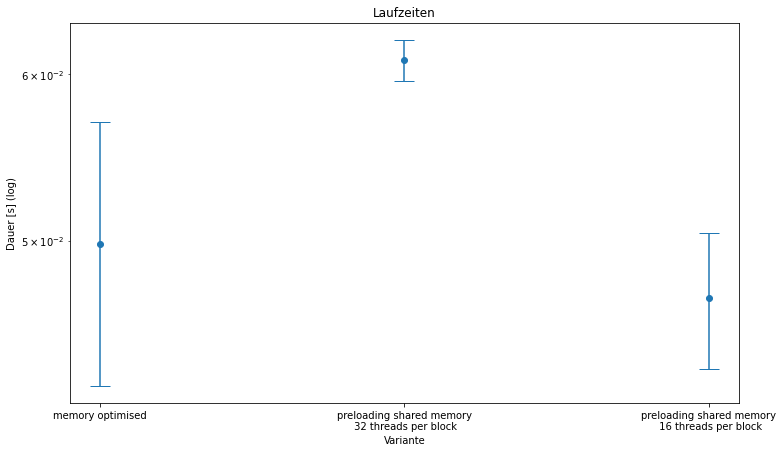

In [65]:
plot_runtimes(
    ['memory optimised', 'preloading shared memory\n 32 threads per block', 'preloading shared memory\n 16 threads per block'],
    [reconstruct_svd_gpu_2, reconstruct_svd_gpu_5, reconstruct_svd_gpu_6]
)


<img src="images/reconstruct_svd_gpu_6.png" alt="Report für Variante 6" width="500"/>

<font color="blue">Diese Optimierungen bringen die Laufzeiten in die Grössenordnung der bisher besten Variante. Tendenziell ist diese sogar leicht schneller als Variante 2. Die Duration konnte laut Report von 92.5 ms auf 85 ms verkürzt werden und es sind entsprechend auch weniger Cylces nötig. Streaming Multiprocessor sind durch die Verkleinerung der Warps wieder beide gleich stark ausgelastet und konnte um 10 Prozentpunkte auf 85 % erhöht werden. 

Aufgrund der kleineren Blöcke haben sich jedoch die Lesezugriffe aufs Global-Memory erhöht. Dies ist auch beim L1- und L2-Cache erkennbar, durch welche die Zugriffe aufs Global-Memory (Device Memory) laufen. Bei der Occupancy sehen wir, dass die Parameter für Block Size und die Grösse des Shared Memory pro Threadblock und der implizite Wert für die Registers pro Thread hinsichtlich der Warp-Auslaustung optimal gewählt wurden.

Die längsten Wartezeiten der Warps fallen nun auf die Zustände *Stall LG Throttle* und *Stall Long Scoreboard*, also warten sie auf die Memory-Komponenten um auf das Global- und Shared-Memory zugreifen zu können.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Diskutiere in ca. 250-300 Wörtern.

In [4]:
### BEGIN SOLUTION

from gpu_lib import reconstruct_multiple_svd

filenames = [os.path.join(folders, name + '.png') for name in names] * 100
print(f'putting {len(filenames)} items in queue')
reconstruct_multiple_svd(filenames, n_processes=3, max_items_on_gpu=3, min_items_on_gpu=2, verbose=False)

### END SOLUTION

putting 700 items in queue


<font color='blue'>Die GPU besteht aus drei Arten von Komponenten, die unabhängig voneinander Arbeiten ausführen können: H2D, Kernel und D2H. Das Ziel sollte sein, dass alle drei Komponenten jeweils bestmöglich ausgelastet sind. Der Prozess um ein einzelnes Bild zu rekonstruieren besteht jeweils aus mehreren H2D-Tasks, der Ausführung des Kernels und einem D2H-Task. Diese müssen jeweils pro Bild in dieser Reihenfolge ausgeführt werden. Um die GPU nun möglichst gut auszulasten, sollen jeweils mehrere Bilder gleichzeitig verarbeitet werden. So sollte für jede Komponente mindestens eine Arbeit bereitstehen, sobald ihr letzter Task abgeschlossen wurde. Zu Beginn startet die H2D-Komponente mit der Kopie der Matrizen. Sobald dies abgeschlossen ist, wird der Kernel ausgeführt und die H2D-Komponente startet mit den nächsten Matrizen für das Bild. Sobald der Kernel für das erste Bild zu Ende ist, übernimmt die D2H-Komponente für dieses Bild und der Kernel startet mit dem zweiten Bild. Währenddessen beginnt die H2D-Komponente mit dem dritten Bild.

Damit die Reihenfolge pro Bild eingehalten werden kann, werden CUDA-Streams eingesetzt. Streams untereinander können gleichzeitig ausgeführt werden, je nach anstehender Aufgabe und verfügbaren Komponenten auf der GPU. Es ist jedoch garantiert, dass die einzelnen Befehle in einem Stream in der Reihenfolge ausgeführt werden, wie sie dem Stream hinzugefügt wurden. Um die Streams genügend schnell befüllen zu können, werden drei Prozesse gestartet und entsprechend auch drei CUDA-Streams. So soll jede GPU-Komponente einen Stream zur Verfügung haben, an dem sie arbeiten kann. Es werden Prozesse und nicht Threads verwendet, da neben der Kommunikation mit der GPU auch die SVD durchgeführt werden muss. Diese wird auf der CPU ausgeführt und ist rechenintensiv. Damit der Standard-Python-Prozess nicht damit blockiert wird und die rechtzeitige Kommunikation mit der GPU sichergestellt werden kann, ist Gleichläufigkeit zwingend. 

Bei dieser Implementierung kann definiert werden wie viele Bilder pro Stream im Minimum vorhanden sein sollen und wieviele maximal. Mit dem Minimum kann vermieden werden, dass ein Stream leer wird. Wenn das Minimum auf 1 gesetzt wird, werden neue Bilder dem Stream hinzugefügt, wenn die GPU mit dem letzten Bild beginnt. Das Maximum dient dazu zu definieren wie viele Bilder maximal dem Stream hinzugefügt werden sollen, um nicht an die Grenzen des Device-Memory zu stossen. Durch Events kann gezählt werden, wie viele Bilder im Stream bereits verarbeitet wurden und entsprechend reagiert werden. Nach der Rekonstruktion eines Bildes wird diese mit dem Orginalbild abgeglichen. Falls diese nicht übereinstimmen sollte, wird ein Fehler geworfen und der ausführende Prozess bricht ab.

Als Kernel wurde die effizienteste Variante, also Nummer 6, verwendet.</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson in ca. 300 Wörtern.

In [21]:
import time

filenames = [os.path.join(folders, name + '.png') for name in names] * 300
print(f'using {len(filenames)} items')

start = time.time()
for filename in filenames:
  # read image
  img = imageio.imread(filename)

  # apply SVD to get U, S, V^T
  img = img - img.min() / img.max() - img.min() # normalize data
  u, s, vt = np.linalg.svd(img, full_matrices=False)

  reco = reconstruct_svd_gpu_6(u, s, vt, u.shape[1])
  np.testing.assert_array_almost_equal(reco, img, decimal=3)

time_for_serial = time.time() - start

results = [{'name': 'serial', 'duration': time_for_serial}]

for n_processes in range(1, 5):
  print(f'starting with {n_processes} process(es)')
  start = time.time()
  reconstruct_multiple_svd(filenames, n_processes=n_processes, max_items_on_gpu=3, min_items_on_gpu=2, verbose=False)
  results.append({'name': f'{n_processes} process(es)', 'duration': time.time() - start})


using 2100 items
/content/drive/MyDrive/adni_png/001/m1-1_slice145.png
/content/drive/MyDrive/adni_png/001/m1-2_slice145.png
/content/drive/MyDrive/adni_png/001/m3-2_slice145.png
/content/drive/MyDrive/adni_png/001/m4-2_slice145.png
/content/drive/MyDrive/adni_png/001/m4-1_slice145.png
/content/drive/MyDrive/adni_png/001/m6-1_slice145.png
/content/drive/MyDrive/adni_png/001/m3-1_slice145.png
/content/drive/MyDrive/adni_png/001/m1-1_slice145.png
/content/drive/MyDrive/adni_png/001/m1-2_slice145.png
/content/drive/MyDrive/adni_png/001/m3-2_slice145.png
/content/drive/MyDrive/adni_png/001/m4-2_slice145.png
/content/drive/MyDrive/adni_png/001/m4-1_slice145.png
/content/drive/MyDrive/adni_png/001/m6-1_slice145.png
/content/drive/MyDrive/adni_png/001/m3-1_slice145.png
/content/drive/MyDrive/adni_png/001/m1-1_slice145.png
/content/drive/MyDrive/adni_png/001/m1-2_slice145.png
/content/drive/MyDrive/adni_png/001/m3-2_slice145.png
/content/drive/MyDrive/adni_png/001/m4-2_slice145.png
/content/dr

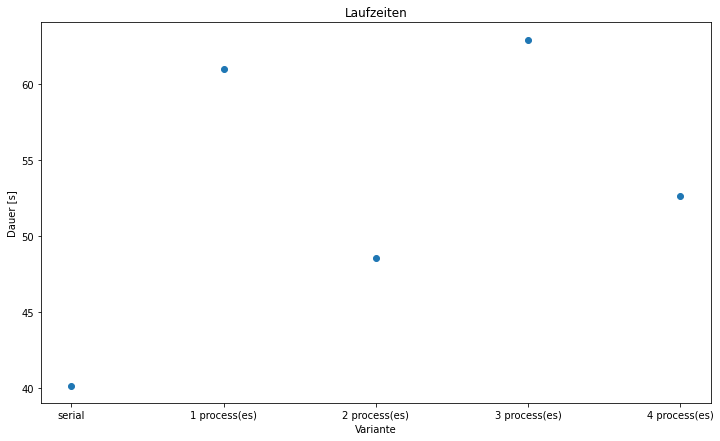

In [20]:
results_df = pd.DataFrame(results)

plt.figure(figsize = (12, 7))
plt.scatter(
    results_df.name,
    results_df.duration
)
plt.title('Laufzeiten')
plt.xlabel('Variante')
plt.ylabel('Dauer [s]')
plt.show()

<font color='blue'>Bei diesen kleinen Matrizen braucht es viele Bilder, damit sich der Einsatz von Multiprocessing wirklich lohnt. Der Overhead zum Starten von Prozessen und dem Prozessmanagement allgemein benötigt viel Zeit. So ist die Version bei drei Prozessen auch nur minim schneller als die serielle Variante. 

Dies ist was Amdahl und Gustafson mit ihren Gesetzen aussagen möchten: Um den Speedup zu berechnen, muss der Code in den seriell ausgeführten und den parallel ausführbaren Teil aufgeteilt werden. Amdahl's Law sagt aus, dass der Code nur soweit beschleunigt werden kann, bis die Laufzeit des seriellen Codes erreicht wurde. Beide unterschlagen jedoch den Overhead, der durch die Parallelisierung verursacht wird, die wie in unserem Fall gut zu erkennen ist, nicht vernachlässigbar ist. Der Unterschied zwischen Amdahl und Gustafson ist, dass Amdahl beschreibt, wie stark die Laufzeit durch Gleichläufigkeit beschleunigt werden kann, währenddessen Gustafson definiert, wie viele Operationen zusätzlich durch mehr Prozessorkerne in der gleichen Zeit ausgeführt werden können.

Da SVD bei dieser Implementierung auf der CPU ausgeführt wird, könnten bei grösseren Bildern die Prozesse ins Hintertreffen gelangen und der GPU nicht mehr rechtzeitig neue Matrizen zur Rekonstruktion übergeben. In diesem Fall könnte man die Anzahl der Prozesse erhöhen, bis die Anzahl Prozessorkerne auf dem System erreicht wurden.

Zu beachten ist, dass dieser Code bei Google Colab ausgeführt wurde, wo in der Regel nur einzelne Prozessorkerne zur Verfügung stehen und so das wirkliche Potenzial von Multiprocessing nicht gezeigt werden kann.</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<img src="images/reconstruction-components.png" alt="Komponentendiagramm für parallele Rekonstruktion" width="500"/>

<font color='blue'>Dieses Komponentendiagramm zeigt einerseits die beteiligten Komponenten und auch was auf der CPU pro Prozess ausgeführt wird und wie die GPU pro Stream arbeitet. Dabei wurde der Ablauf möglichst einfach gehalten und die Aktionen im Prozess und im Stream wiederholen sich bis alle Bilder abgearbeitet wurden. 

Die Prozesse auf der CPU und die Streams auf der GPU arbeiten bis auf die Synchronisation mittels Events unabhängig voneinander. Die CPU übergibt der GPU Tasks (Kopieren H2D, Ausführen des Kernels und Kopieren D2H), die diese ausführt, sobald Ressourcen für die jeweilige Aktion verfügbar sind. Die einzelnen Komponenten auf der GPU arbeiten dabei für unterschiedliche Streams und entsprechend auch unterschiedliche Prozesse. Dabei beachten sie aber die Reihenfolge der Tasks im Stream.</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Bevor Code bezüglich seiner Laufzeit optimiert wird, sollte untersucht werden, wo dessen Bottlenecks und rechenintensiven Bereiche liegen, damit man geeignete Anpassungen vornehmen kann. Je nach Problem besteht die Möglichkeit zur Parallelisierung gewisser Code-Teil (Prozesse, Threads), der Vektorisierung von Rechenoperationen und der Auslagerung von Teilen auf die GPU. Bei vielen I/O-Zugriffen lohnt sich bereits der Einsatz von Multithreading. Bei rechenintensiven Operationen muss auf Vektorisierung, Multiprocessing oder die GPU zurückgegriffen werden. Dabei sollte Amdahl's und Gustafson's Law nicht vergessen werden.</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Der CPU-Code setzt grundsätzlich auf *Single Instruction, Single Data* und der GPU-Kernel ist auf Basis von *Single Instruction, Multiple Data* aufgebaut. Bei der CPU wird jedes Statement einzeln mit den jeweiligen Daten abgearbeitet, auch wenn andere Prozesse die gleiche Operation mit anderen Daten durchführen. Bei der GPU wird ein Kernel gleichzeitig und schrittweise in einem ganzen Warp abgearbeitet.

Aktuelle CPUs enthalten auch Komponenten mit einer SIMD-Architektur (zum Beispiel AVX bei Intel). Bei dieser Mini-Challenge wird numpy verwendet, das einige Operationen auch mittels SIMD auf der CPU optimiert: [numpy Dokumentation](https://numpy.org/devdocs/reference/simd/index.html)</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Da sich die Bilder bereits im Arbeitsspeicher befinden, haben wir es vor allem mit CPU-Problemen zu tun. Die Berechnung hat eine Komplexität von $O(n^3)$ und ist somit sehr rechenintensiv.</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Wenn der gesamte Prozess (Zerlegung, Rekonstruktion, Überprüfung) damit umgesetzt werden sollte, könnte man die einzelnen Schritte als separate Services implementieren. Ein Producer führt SVD aus, ein weiterer Producer führt die Rekonstruktion durch und ein Consumer überprüft die Rekonstruktion mit den ursprünglichen Daten. So kann die Hardware für die einzelnen Services auch entsprechend dimensioniert werden. Für die Rekonstruktion sind sicher Server mit GPU-Leistung nötig, auf die bei der Überprüfung auch verzichtet werden kann. Die Hardware-Leistung kann so ideal auf die Anforderungen der einzelnen Schritte angepasst werden, so dass es zu keinem Bottleneck kommt. Für die Kommunikation zwischen den Services müsste eine passende Methode gefunden werden, da die Bilder und die Rekonstruktion sehr gross sind, was insbesondere zu Problemen führen kann, wenn die Services keine schnelle Verbindung untereinander haben (und sich zum Beispiel in unterschiedlichen Rechenzentren befinden). Die Daten könnten auf einem zentralen und schnellen Datenspeicher abgelegt werden und über den Broker nur die ID der einzelnen Datenblöcke übermittelt werden. So bleiben die Messages klein, was beispielsweise bei Kafka von Vorteil ist.</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Die Verwendung der GPU ist mit Overhead verbunden, da Daten zwischen Host und Device kopiert werden müssen. Deshalb muss dieser Overhead kompensiert wird, was durch die Umsetzung des *Single Instruction, Multiple Data*-Paradigma ermöglicht werden kann. Anweisungen sollen auf so vielen Daten wie möglich gleichzeitig ausgeführt werden können. Zudem sollen die Memory-Operationen auf der GPU (vor allem auf dessen Global-Memory) so stark reduziert werden wie nur möglich. Wenn auf dieses zugegriffen wird, sollen diese Zugriffe möglichst coallesced sein, damit die Zugriffe kombiniert werden können und nicht für jeden Thread ein eigener langsamer Zugriff durchgeführt werden muss. Beim Shared-Memory sollen die Zugriffe keine Bank Conflicts auslösen, damit auch hier die Zugriffe parallelisiert werden können.</font>

6: Reflektiere die Mini-Challenge in ca. 300-500 Zeichen. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Ich fand die Mini-Challenge von der Thematik her sehr spannend. Programmierung auf der GPU habe ich bisher noch nicht gemacht und konnte mir auch nicht vorstellen, wie das konkret funktioniert und auf was man dort achten muss. Ich war erstaunt, dass es sogar für die interpretierte Sprache Python eine saubere Abstraktion von CUDA gibt. Die Umsetzung war komplexer als ich das erwartet hatte. Es brauchte eine Weile bis ich die verschiedenen Konzepte und Komponenten der GPU (Threads, Warps, Threadblöcke, Shared Memory, etc.) verstanden hatte.

Multihreading und Multiprocessing habe ich zu einem Teil auch schon bei der ersten Mini-Challenge anwenden können, wobei ich dieses Mal wieder einige neue Werkzeuge ausprobieren konnte. Dabei bin ich auch auf Probleme gestossen, wie zum Beispiel dass CUDA plötzlich unter gewissen Umständen Probleme mit mehreren Prozessen hatte. Mit der Fork-Strategie wurden auch CUDA-Objekte in die Subprozesse übernommen, was nicht erlaubt war. Bei der Spawn-Strategie musste ich anschliessend auch die Queue speziell aus diesem Spawn-Prozess erstellen, damit diese korrekt funktionierte.

Bei einer nächsten Durchführung dieser Mini-Challenge würde ich statt den kleinen ADNI-Bildern, viel grössere und auch die Menge dieser vergrössern, damit die Optimierungen auch wirklich gemessen werden können. Bei so kleinen Datenmengen fällt der Effekt klein aus oder die Optimierungen sind langsamer als die ursprüngliche Version, da der Overhead zu gross ist.

Ich fand es gut, dass die Mini-Challenge mit einfachen Aufgaben begonnen hat, so dass man sich an die Thematik und die Problemstellung gewöhnen kann. Ich würde aber die einzelnen Aufgaben nicht mehr so klar strukturieren, sondern mehr Freiraum geben, so dass man selbst entscheiden könnte, ob man nochmals zwei Numpy-Broadcasting-Varianten implementieren möchte, wenn man dieses Konzept bereits bei anderen Varianten eingesetzt hat.</font>